## Import packages

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tensorflow and the Keras classes needed to construct our model.

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, SDG

import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_local_zip = '/content/drive/MyDrive/lulc-tra-val.zip'
zip_ref = zipfile.ZipFile(train_local_zip, 'r')
zip_ref.extractall('/content/sample_data/lulc-tra-val')

test_local_zip = '/content/drive/MyDrive/test.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/content/sample_data/lulc-tra-val/lulc-classificatio')

zip_ref.close()

In [ ]:
PATH = '/content/sample_data/lulc-tra-val/lulc-classificatio'

After extracting its contents, assign variables with the proper file path for the training and validation set.

In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

In [ ]:
train_BarrenLands_dir = os.path.join(train_dir, '1_BarrenLands___jpeg')
validation_BarrenLands_dir = os.path.join(validation_dir, '1_BarrenLands___jpeg')

In [ ]:
num_barren_tr = len(os.listdir(train_BarrenLands_dir))
num_barren_val = len(os.listdir(validation_BarrenLands_dir))

print('total training barren images:', num_barren_tr)
print('total validation barren images:', num_barren_val)

total training barren images: 283
total validation barren images: 71


In [ ]:
batch_size = 64
epochs = 15
img_height = 160
img_width = 160

## Training and Validation Generators

Now that you know the images you are dealing with, it is time for you to code the generators that will fed these images to your Network. For this, complete the `train_val_generators` function below:

**Important Note:** The images have a resolution of 300x300 but the `flow_from_directory` method you will use allows you to set a target resolution. In this case, **set a `target_size` of (150, 150)**. This will heavily lower the number of trainable parameters in your final network, yielding much quicker training times without compromising the accuracy!

In [ ]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values and set arguments to augment the images 
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=batch_size, 
                                                      class_mode='categorical',
                                                      target_size=(img_width, img_height))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(
      rescale=1./255,
      )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=batch_size, 
                                                                class_mode='categorical',
                                                                target_size=(img_width, img_height))
  ### END CODE HERE
  return train_generator, validation_generator


In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 8207 images belonging to 29 classes.
Found 2059 images belonging to 29 classes.


**Expected Output:**
```
Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
```

## Transfer learning - Create the pre-trained model

Download the `inception V3` weights into the `/tmp/` directory:

In [ ]:
# Download the inception v3 weights
#!wget --no-check-certificate \
#    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-03-27 10:23:27--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   164MB/s    in 0.5s    

2022-03-27 10:23:28 (164 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Now load the `InceptionV3` model and save the path to the weights you just downloaded:

In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
#local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

Complete the `create_pre_trained_model` function below. You should specify the correct `input_shape` for the model (remember that you set a new resolution for the images instead of the native 300x300) and make all of the layers non-trainable:

Check that everything went well by comparing the last few rows of the model summary to the expected output:

In [ ]:
# GRADED FUNCTION: create_pre_trained_model
#def create_pre_trained_model(local_weights_file):
  ### START CODE HERE
pre_trained_model = InceptionV3(input_shape = (img_width, img_height, 3),
                                  include_top = False, 
                                  weights = 'imagenet') 

  #pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

  ### END CODE HERE

  #return pre_trained_model
  

87924736/87910968 [==============================] - 4s 0us/step


In [ ]:
#pre_trained_model.trainable = False
#pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

**Expected Output:**
```
batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
__________________________________________________________________________________________________
activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
__________________________________________________________________________________________________
mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
                                                                activation_276[0][0]             
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
                                                                activation_280[0][0]             
__________________________________________________________________________________________________
activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
__________________________________________________________________________________________________
mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
                                                                mixed9_1[0][0]                   
                                                                concatenate_5[0][0]              
                                                                activation_281[0][0]             
==================================================================================================
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784


```

To check that all the layers in the model were set to be non-trainable, you can also run the cell below:

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


**Expected Output:**
```
There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.
```

## Creating callbacks for later

You have already worked with callbacks in the first course of this specialization so the callback to stop training once an accuracy of 99.9% is reached, is provided for you:

## Pipelining the pre-trained model with your own

Now that the pre-trained model is ready, you need to "glue" it to your own model to solve the task at hand.

For this you will need the last output of the pre-trained model, since this will be the input for your own. Complete the `output_of_last_layer` function below.

**Note:** For grading purposes use the `mixed7` layer as the last layer of the pre-trained model. However, after submitting feel free to come back here and play around with this.

In [ ]:
# GRADED FUNCTION: output_of_last_layer
def output_of_last_layer(pre_trained_model):
  ### START CODE HERE
  last_desired_layer = pre_trained_model.get_layer('mixed9')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  ### END CODE HERE

  return last_output


Check that everything works as expected:

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 3, 3, 2048)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3, 2048), dtype=tf.float32, name=None), name='mixed9/concat:0', description="created by layer 'mixed9'")


**Expected Output (if `mixed7` layer was used):**
```
last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")
```

Now you will create the final model by adding some additional layers on top of the pre-trained model.

Complete the `create_final_model` function below. You will need to use Tensorflow's [Functional API](https://www.tensorflow.org/guide/keras/functional) for this since the pretrained model has been created using it. 

Let's double check this first:

In [ ]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


To create the final model, you will use Keras' Model class by defining the appropriate inputs and outputs as described in the first way to instantiate a Model in the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

Note that you can get the input from any existing model by using its `input` attribute and by using the Funcional API you can use the last layer directly as output when creating the final model.

In [ ]:
# GRADED FUNCTION: create_final_model
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  ### START CODE HERE

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(64, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.4)(x)   
  # Add a final sigmoid layer for classification
  x = layers.Dense(29, activation='softmax')(x)


  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  base_learning_rate = 0.001
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model


In [ ]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 16,904,317 total parameters in this model.
There are 1,181,597 trainable parameters in this model.


**Expected Output:**
```
There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.
```

Wow, that is a lot of parameters!

After submitting your assignment later, try re-running this notebook but use the original resolution of 300x300, you will be surprised to see how many more parameters are for that case.

Now train the model:

In [ ]:
#Checkpoint In the /output folder
filepath = '/content/sample_data/lulc-tra-val/best_model_lulc.hdf5'
# Keep only a single checkpoint, the best over test accuracy.
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take a few epochs)
#callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    #steps_per_epoch = num_barren_tr // batch_size,
                    epochs = 10,
                    #validation_steps = num_barren_val // batch_size,
                    verbose = 1,
                    callbacks=checkpoint)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


129/129 [==============================] - ETA: 0s - loss: 2.4429 - accuracy: 0.3041
Epoch 1: val_accuracy did not improve from 0.52161
129/129 [==============================] - 75s 542ms/step - loss: 2.4429 - accuracy: 0.3041 - val_loss: 1.8763 - val_accuracy: 0.4109
Epoch 2/10
129/129 [==============================] - ETA: 0s - loss: 1.9099 - accuracy: 0.4182
Epoch 2: val_accuracy did not improve from 0.52161
129/129 [==============================] - 70s 543ms/step - loss: 1.9099 - accuracy: 0.4182 - val_loss: 1.5887 - val_accuracy: 0.4896
Epoch 3/10
129/129 [==============================] - ETA: 0s - loss: 1.7388 - accuracy: 0.4584
Epoch 3: val_accuracy did not improve from 0.52161
129/129 [==============================] - 70s 543ms/step - loss: 1.7388 - accuracy: 0.4584 - val_loss: 1.5088 - val_accuracy: 0.5158
Epoch 4/10
129/129 [==============================] - ETA: 0s - loss: 1.6348 - accuracy: 0.4921
Epoch 4: val_accuracy did not improve from 0.52161
129/129 [============

The training should have stopped after less than 10 epochs and it should have reached an accuracy over 99,9% (firing the callback). This happened so quickly because of the pre-trained model you used, which already contained information to classify humans from horses. Really cool!

Now take a quick look at the training and validation accuracies for each epoch of training:

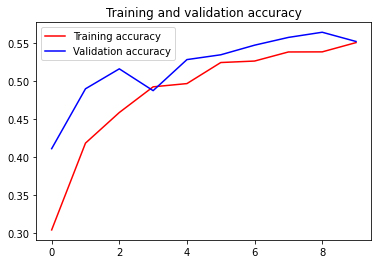

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

You will need to submit this notebook for grading. To download it, click on the `File` tab in the upper left corner of the screen then click on `Download` -> `Download .ipynb`. You can name it anything you want as long as it is a valid `.ipynb` (jupyter notebook) file.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a convolutional neural network that leverages a pre-trained network to help you solve the problem of classifying humans from horses.

**Keep it up!**